In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys, rospy, rosbag, glob, re, math

import scipy
import scipy.stats
from scipy.stats import pearsonr
from scipy.optimize import minimize

from smap.msg import smapStats

from IPython.display import HTML, display

from matplotlib.path import Path
import matplotlib.patches as patches
from matplotlib import cm
from numpy import linspace
from matplotlib.colors import LogNorm

Optimization terminated successfully.
         Current function value: 0.879867
         Iterations: 7
         Function evaluations: 3591
  status: 0
 success: True
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00],
       [  0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,

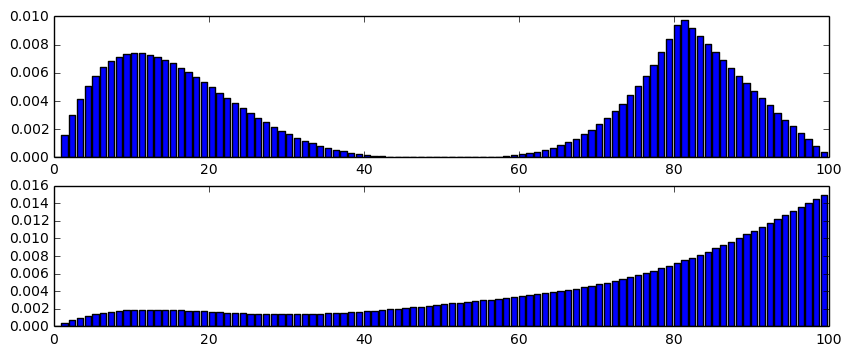

In [178]:
%matplotlib inline
fig, ((ax1, ax2)) = plt.subplots(2, 1, figsize=(10, 4))

num_particles = 100
prior_mean = 0.6
prior_var = 0.25

particle_supports = np.linspace(0, 1, num_particles, endpoint=True)

n = num_particles
coeff1 = (4.*n-2.-6.*(n-1)* prior_mean)/(n*n+n)
coeff2 = -coeff1+2./n
initial_belief = np.array(coeff2-(coeff2-coeff1)*particle_supports)

params = [
    0.1,
    3.5,
    0.0000123,
    .0,
    .0,
    1,
    0,
    0,
    0,
    0
]

def generate_pdf(params):
    belief = [b * min(params[0] * (100-x) + params[6] * x + params[7],
                                 max(abs(params[0]) ** (params[1]) + params[9],
                                     params[2] * abs(x-n/2) ** abs(params[1])
                                     + (n-x) * params[3]
                                     + x * params[4] + params[8]) * params[5])
              for b, x in zip(initial_belief, list(range(n+1)))]
    return np.array(belief)

def particle_opt(params):
#     print params

    belief = generate_pdf(params)
    mean = np.sum(belief * particle_supports)
    return abs(1. - np.sum(belief)) \
            + 2 * abs(prior_mean - mean) \
            + 4 * abs(prior_var - (np.sum(belief * particle_supports**2) - mean**2)) \
            + 10 * len(belief[belief < 0])


def direct_opt(belief):
    mean = np.sum(belief * particle_supports)
    #return abs(1. - np.sum(belief)) + 200 * abs(0.5 - mean) + 4 * abs(0.25 - (np.sum(belief * particle_supports**2) - mean**2))
    return abs(1. - np.sum(belief)) \
            + 2 * abs(0.5 - mean) \
            + 4 * abs(0.25 - (np.sum(belief * particle_supports**2) - mean**2)) \
            + 10 * len(belief[belief < 0])


pdf = generate_pdf(params)
ax1.bar(list(range(n)), pdf * particle_supports)

mean = np.sum(pdf * particle_supports)
# print "Sum: ", np.sum(pdf)
# print "Mean:", mean
# print "Std: ", np.sqrt(np.sum(pdf * particle_supports**2) - mean**2)

#res = minimize(particle_opt, params, method='COBYLA', tol=0.01, options={'tol': 1e-1, 'disp': True, 'maxiter': 1000})
res = minimize(particle_opt, params, method='Powell', options={'xtol': 1e-35, 'ftol': 1e-35, 'disp': True, 'maxiter': 20000, 'maxfev': 20000})
#res = minimize(direct_opt, np.random.rand(n)/10, method='Nelder-Mead', options={'xtol': 1e-5, 'disp': True, 'maxiter': 100})
print res

minimizer_kwargs = {"method": "Powell"}
res = scipy.optimize.basinhopping(particle_opt, params, minimizer_kwargs=minimizer_kwargs, niter=100)

# minimizer_kwargs = {"method": "Powell"}
# ret = scipy.optimize.basinhopping(direct_opt, generate_pdf(params), minimizer_kwargs=minimizer_kwargs, niter=100)
# print ret

pdf = generate_pdf(res.x)
mean = np.sum(pdf * particle_supports)
print "Sum: ", np.sum(pdf)
print "Mean:", mean
print "Std: ", np.sqrt(np.sum(pdf * particle_supports**2) - mean**2)
ax2.bar(list(range(n)), pdf * particle_supports)
print pdf
#ax2.bar(list(range(n)), ret.x * particle_supports)

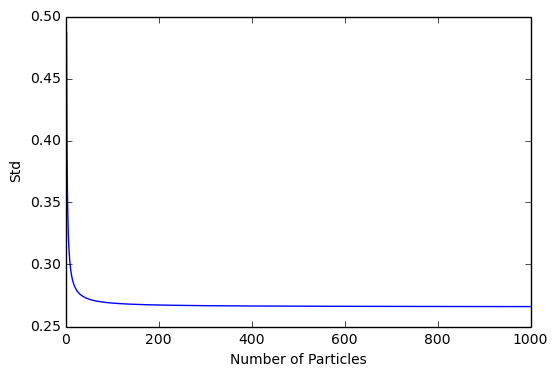

In [173]:
%matplotlib inline
num_particles = 2000


def part_std(n):
    particle_supports = np.linspace(0, 1, n, endpoint=True)
    coeff1 = (4.*n-2.-6.*(n-1)* prior_mean)/(n*n+n)
    coeff2 = -coeff1+2./n
    initial_belief = np.array(coeff2-(coeff2-coeff1)*particle_supports)
    return np.sqrt(np.sum(initial_belief * particle_supports**2) - mean**2)

x = list(range(2, 1000))
plt.plot(x, [part_std(n) for n in x])
plt.xlabel("Number of Particles")
plt.ylabel("Std")